In [9]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。
# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
sys.path.append("../ecg-classification/")
# sys.path.append("C:\\Users\\Chen_Lab01\\Documents\\GitHub/ecg-classification")
# from IPython.display import Video
# import cv2
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
import matplotlib
matplotlib.use("TkAgg")
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。
# print(sys.path)
from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer



## Data

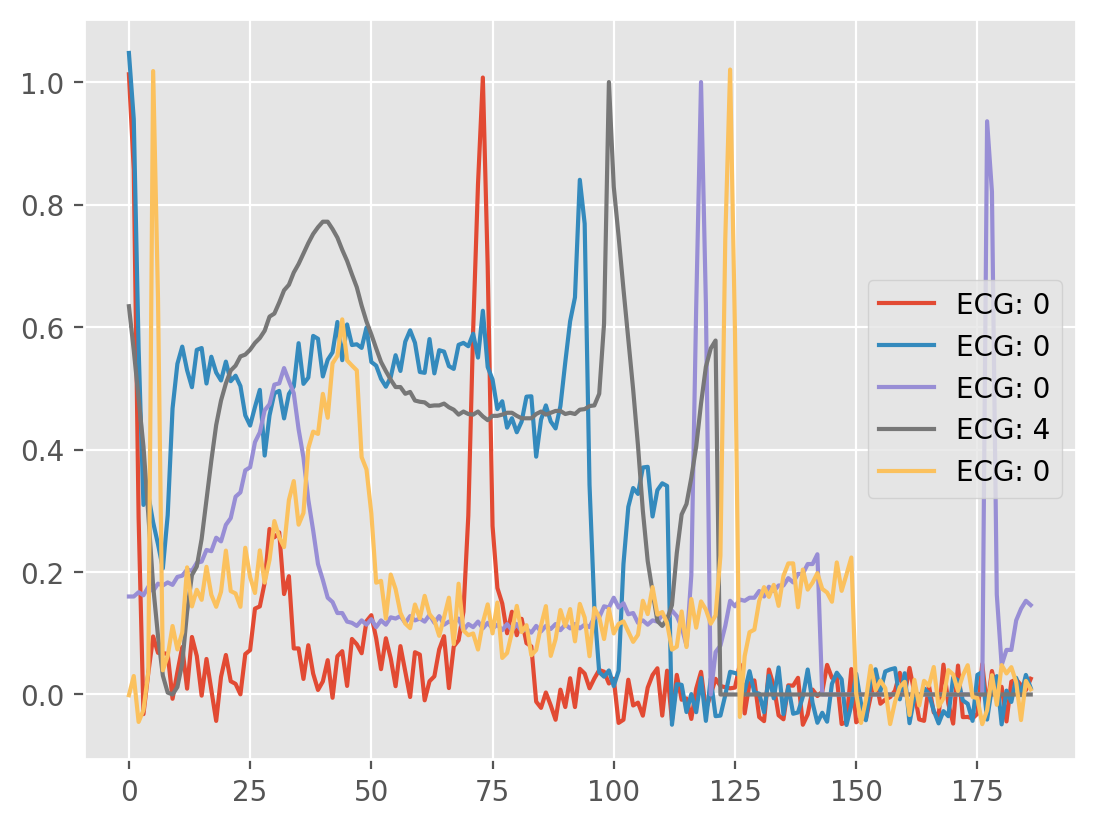

In [10]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

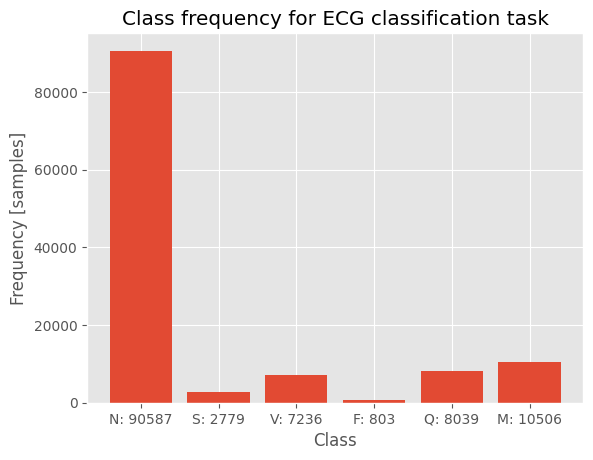

In [11]:
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)
classes = ["N", "S", "V", "F", "Q", "M"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [12]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model
from torchinfo import summary
# input = (batch_size, signal_length, input_channels)
summary(model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層
# print(model)




Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            384                       --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Quantization Test

In [13]:
# import torch.quantization
# model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
# quantized_model = torch.quantization.quantize_dynamic(
#     model, {torch.nn.Linear}, dtype=torch.qint8
# )

# quantized_model
# from torchinfo import summary
# summary(quantized_model, input_size=(64, config.model.signal_length, 1),
#        device='cpu',
#        col_names=("input_size", "output_size", "num_params", "kernel_size"),
#        depth=5) # depth = 3 表示只顯示到第三層
# # print(model)


### Model ParameterTest

In [14]:
# for name in quantized_model.state_dict():
#    print(name)
# 
# print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

### Visualize Model

In [15]:
# quantized_model.eval()
# inputs = torch.randn(1, 187, 1)
# traced_script_module = torch.jit.trace(quantized_model, inputs)
# traced_script_module.save("traced_resnet_model.pth")

# from torchviz import make_dot
# vis_graph = make_dot(quantized_model(inputs), params=dict(quantized_model.named_parameters()), show_attrs=True, show_saved=True)
# vis_graph.view()  # 会在当前目录下保存一个“Digraph.gv.pdf”文件，并在默认浏览器中打开

# import netron
# modelData = 'traced_resnet_model.pth'
# netron.start(modelData)

## Training

TRAINING: 0, loss: 0.745170533657074. Target: [4, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [01:38<00:00, 30.59it/s]  


TRAINING Accuracy: 0.7733619213104248
[[69904     8   665     7  1885     1]
 [ 2148     9    19     0    46     1]
 [ 4199     3   795     3   787     1]
 [  636     0     3     2     0     0]
 [ 2838     0    85     0  3508     0]
 [ 7764     2   163     0   476     0]]
epoch_loss: 0.0002484730022197646


RuntimeError: Parent directory model_save does not exist.

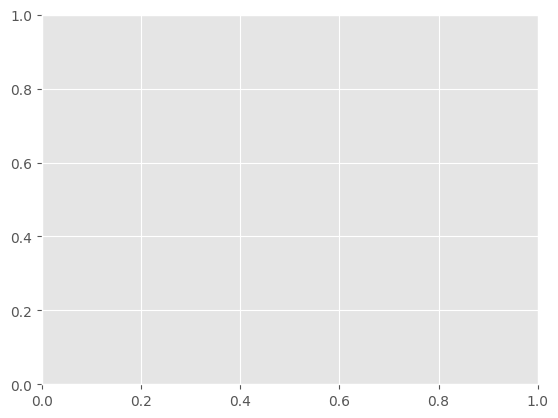

In [16]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

## Evaluating

In [ ]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

In [ ]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


## Save model and load model

In [ ]:
import torch
model.eval()
torch.save(model, "..\\model_save\\model.pth")
model_test = torch.load("..\\model_save\\model.pth")
print(model_test)

In [ ]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
quantized_model.eval()
torch.save(quantized_model, "..\\model_save\\model_quantized.pth")
model_test = torch.load("..\\model_save\\model_quantized.pth")

print(model_test)


In [ ]:
import einops
loader = get_data_loaders(DatasetConfig())
accuracy = 0
for signal, label in loader[Mode.eval]:
    p = model_test(einops.rearrange(signal, "b c e -> b e c"))
    print(p)
    print(label)
    # print(signal.shape, label.shape)
    print(p.argmax(1))
    print(p.argmax(1) == label)
    accuracy += torch.sum(p.argmax(1) == label)
    print(f"accuracy: {accuracy / config.dataset.batch_size}")
    break



## Parameter 提取

In [ ]:
for name in model_test.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])